In [17]:
import numpy as np
import cartopy.crs as ccrs
from rasterio.plot import show
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import rasterio  
from pyproj import CRS
from matplotlib.patches import Polygon
from rasterio.warp import calculate_default_transform, reproject, Resampling
from cartopy.mpl.geoaxes import GeoAxes

In [19]:
def reproject_raster(src, target_crs):
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds)
    dst_array = np.zeros((src.count, height, width), dtype=src.dtypes[0])
    reproject(
        source=src.read(),
        destination=dst_array,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=target_crs,
        resampling=Resampling.bilinear)
    left, bottom = transform * (0, height)
    right, top = transform * (width, 0)
    return dst_array, [left, right, bottom, top]

In [ ]:
def linear_stretch(band, lower_percent=2, upper_percent=98):
    low = np.percentile(band, lower_percent)
    high = np.percentile(band, upper_percent)
    stretched = np.clip((band - low) / (high - low), 0, 1)
    return stretched

In [ ]:
#添加指北针
def add_compass(ax, location=(0.95, 0.85), size=0.05,
               color_black='black', color_white='white',
               edge_color='gray', edge_width=1,
               projection=None, text_offset=0.02):
    """添加指北针（兼容任意投影）"""
    if projection is None:
        projection = ax.projection
    
    xmin, xmax, ymin, ymax = ax.get_extent()
    
    # 计算中心点
    x_center = xmin + (xmax - xmin) * location[0]
    y_center = ymin + (ymax - ymin) * location[1]
    
  
    width = (xmax - xmin) * size
    height = (ymax - ymin) * size * 2

    # 定义三角形顶点
    top = (x_center, y_center + height / 2)
    bottom_left = (x_center - width / 2, y_center - height / 2)
    bottom_right = (x_center + width / 2, y_center - height / 2)
    mid_bottom = (x_center, y_center - height / 2 * 0.2)

    # 绘制指北针
    ax.add_patch(Polygon([top, bottom_left, mid_bottom], 
                facecolor=color_white, edgecolor=edge_color, 
                linewidth=edge_width, transform=projection))
    ax.add_patch(Polygon([top, bottom_right, mid_bottom], 
                facecolor=color_black, edgecolor=edge_color,
                linewidth=edge_width, transform=projection))
    
    # 添加N标记
    ax.text(x_center, y_center + height / 2 + (ymax - ymin) * text_offset, 'N',
            fontsize=18, ha='center', va='bottom', transform=projection)


不进行投影判断

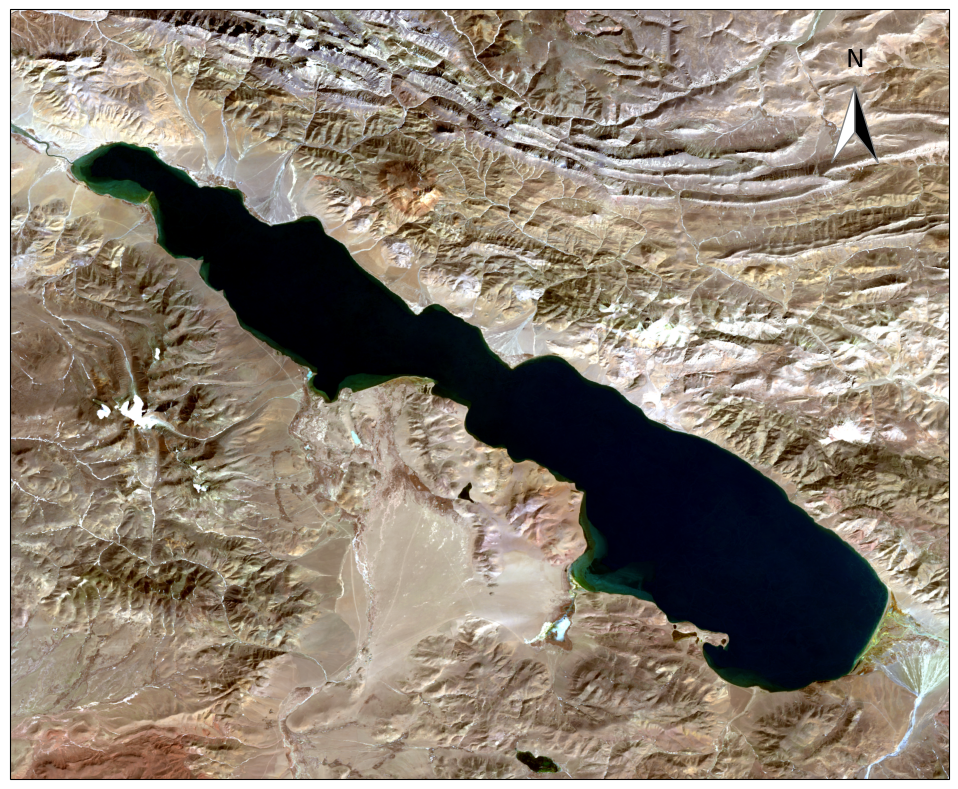

In [32]:
path_rsimg = r'D:\Desktop\Sentinel_6\gerencuo\Landsat_2024.tif'
with rasterio.open(path_rsimg) as src:
    bounds = src.bounds
    center_lon = (bounds.left + bounds.right) / 2
    center_lat = (bounds.top + bounds.bottom) / 2
    zone = int((center_lon + 180) / 6) + 1
    southern = center_lat < 0
    utm_crs = ccrs.UTM(zone=zone, southern_hemisphere=southern)
    
    # 读取RGB波段并进行线性拉伸
    red = src.read(4)
    green = src.read(3)
    blue = src.read(2)
    img_rgb = np.dstack([linear_stretch(red), linear_stretch(green), linear_stretch(blue)])

    # 创建图形
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': utm_crs})
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    ax.imshow(img_rgb, origin='upper', extent=extent)
    
    # 添加指北针
    add_compass(ax, location=(0.9, 0.85), size=0.05, projection=utm_crs)
    plt.tight_layout()
    plt.show()

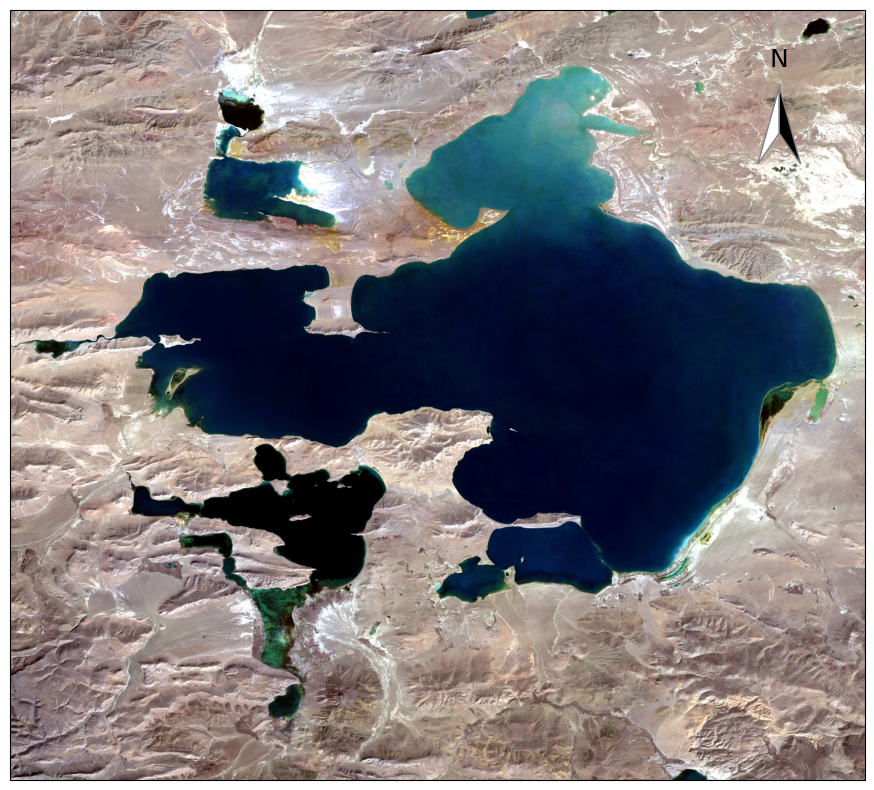

In [33]:
path_rsimg = r'D:\Desktop\Sentinel_6\selincuo\Landsat_2024.tif'
with rasterio.open(path_rsimg) as src:
    bounds = src.bounds
    center_lon = (bounds.left + bounds.right) / 2
    center_lat = (bounds.top + bounds.bottom) / 2
    zone = int((center_lon + 180) / 6) + 1
    southern = center_lat < 0
    utm_crs = ccrs.UTM(zone=zone, southern_hemisphere=southern)
    
    # 读取RGB波段并进行线性拉伸
    red = src.read(4)
    green = src.read(3)
    blue = src.read(2)
    img_rgb = np.dstack([linear_stretch(red), linear_stretch(green), linear_stretch(blue)])

    # 创建图形
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': utm_crs})
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    ax.imshow(img_rgb, origin='upper', extent=extent)
    
    # 添加指北针
    add_compass(ax, location=(0.9, 0.85), size=0.05, projection=utm_crs)
    plt.tight_layout()
    plt.show()

进行投影判断

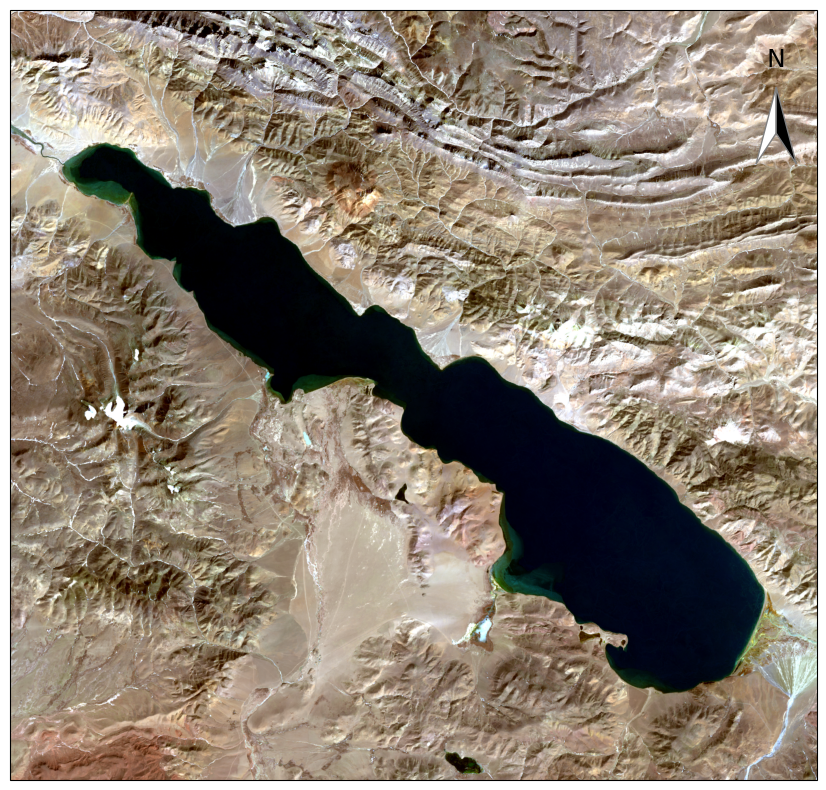

In [34]:
# 读取影像
path_rsimg = r'D:\Desktop\Sentinel_6\gerencuo\Landsat_2024.tif'
with rasterio.open(path_rsimg) as src:
    if src.crs is None or not src.crs.is_projected:
        center_lon = (src.bounds.left + src.bounds.right) / 2
        zone = int((center_lon + 180) / 6) + 1
        is_south = src.bounds.bottom < 0
        target_crs = ccrs.UTM(zone=zone, southern_hemisphere=is_south)
        img_data, extent = reproject_raster(src, target_crs)
    else:
        target_crs = ccrs.Projection(src.crs)
        img_data = src.read()
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # 读取RGB波段并进行线性拉伸
    red = src.read(4)
    green = src.read(3)
    blue = src.read(2)
    img_rgb = np.dstack([linear_stretch(red), linear_stretch(green), linear_stretch(blue)])
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1,1,1, projection=target_crs)
   
    ax.imshow(img_rgb, extent=extent, origin='upper')

    # 添加指北针，无变化
    add_compass(ax, projection=target_crs)
    plt.tight_layout()
    plt.show()